In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
import requests
import geopandas as gpd
import rasterio as rio
from libpysal import weights
from sklearn.cluster import AgglomerativeClustering


c:\Users\juanm\geopandas_env\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
c:\Users\juanm\geopandas_env\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
c:\Users\juanm\geopandas_env\lib\site-packages\libpysal\cg\alpha_shap

In [2]:
# Leer las comunas de la Región Metropolitana desde un archivo shapefile y dejar en crs epsg:4326
comunas = gpd.read_file('data\Comunas\comunas.shp').to_crs(epsg=4326)
# Guardar la comuna Maipu en un archivo shapefile solo con su geometría
maipu = comunas[comunas['Comuna'] == 'Maipú'].reset_index(drop=True)
maipu = maipu['geometry']
# Pasar a geodataframe maipu
maipu = gpd.GeoDataFrame(geometry=maipu)

In [3]:
import geemap
import ee
# Iniciar flujo de autentificación 
#ee.Authenticate()
 
# Inicializar la librería.
ee.Initialize()

In [4]:
# Abrir data\Areas_urbanas\%C3%81rea_Urbana_de_Santiago_PRMS100.shp
areas_urbanas = gpd.read_file('data\Areas_urbanas\%C3%81rea_Urbana_de_Santiago_PRMS100.shp').to_crs('EPSG:4326')
# Me quedo con las COMUNA = Comunas del Gran Santiago
areas_urbanas = areas_urbanas[areas_urbanas['COMUNA'] == 'Comunas del Gran Santiago']
# intersectar con el poligono de maipu
areas_urbanas_maipu = gpd.overlay(areas_urbanas, maipu, how='intersection')
# convertir a geodataframe con crs = 'EPSG:4326'
areas_urbanas_maipu = gpd.GeoDataFrame(areas_urbanas_maipu, crs='EPSG:4326')

zonas_urbanas_json = areas_urbanas_maipu.to_json()
zonas_urbanas_json = json.loads(zonas_urbanas_json)
zonas_urbanas_geometry = ee.Geometry.MultiPolygon(zonas_urbanas_json['features'][0]['geometry']['coordinates'])

In [5]:
aoi = zonas_urbanas_geometry

collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate('2023-01-01', '2023-06-28').sort('CLOUDY_PIXEL_PERCENTAGE',True)

#tomemos una imagen random de la collection
lest_cloudly = collection.toList(72).get(1)

#clip the image to the aoi
clipped_image = ee.Image(lest_cloudly).clip(aoi)

In [6]:
# calculemos el NDBI

ndbi =  clipped_image.normalizedDifference(['B11', 'B8'])

ndbi_vis_params = {'min': -1, 'max': 1, 'palette': ['lightgreen','purple']}

# calculemops el NDVI

ndvi = clipped_image.normalizedDifference(['B8', 'B4'])

ndvi_vis_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white','green']}

# creemosu un trheshold para el ndvi
ndvi_threshold = ndvi.gt(0)

ndvi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

ndbi_threshold = ndbi.gt(0.02)

ndbi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['green','purple']}

# veamos la imagen del 2023 clipeada al zona urbana de maipu
Maipu_2023 = clipped_image.clip(zonas_urbanas_geometry)


In [7]:
#visualicemos el ndbi

Map = geemap.Map()

Map.centerObject(zonas_urbanas_geometry, 12)

Map.addLayer(clipped_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2023')
Map.addLayer(ndbi_threshold, ndbi_threshold_vis_params, 'NDBI')
Map.addLayer(ndbi,ndbi_vis_params, 'sgsd')

Map

Map(center=[-33.517396555511816, -70.76292036796465], controls=(WidgetControl(options=['position', 'transparen…

In [8]:
# Define la URL de la consulta
url = "https://sitmaipu.cl/arcgis/rest/services/Servicios/PRC_Zonificacion/MapServer/1/query"

# Define los parámetros de la consulta
params = {
    "f": "geoJSON",
    "where": "ZONA='ZC1' OR ZONA='ZC2' OR ZONA='ZC3' OR ZONA='ZC4' OR  ZONA='ZH1' OR ZONA='ZH2' OR ZONA='ZH3' OR ZONA='ZH4' OR ZONA='ZH5' OR ZONA='ZH6' OR ZONA='ZH7' OR ZONA='ZH8' OR ZONA='ZH9' OR ZONA='ZH10' OR ZONA='ZE5'",
    "outFields": "*",
    "returnGeometry": "true"
}

# Realiza la consulta
response = requests.get(url, params=params)

# Comprueba que la consulta fue exitosa
response.raise_for_status()

# Convierte la respuesta a JSON
data = response.json()

# Extrae las características (features) de la respuesta
features = data["features"]

# Filtra las características que tienen una geometría
features_with_geometry = [f for f in features if f["geometry"] is not None]

In [9]:
# crear un GeoDataFrame con los polígonos y guardando la descripción de cada polígono
zonas_habitacionales_maipu = gpd.GeoDataFrame.from_features(features_with_geometry)


In [10]:
zonas_habitacionales_maipu.head(1)

,geometry,OBJECTID,ZONA,NOMBRE,CARACTERISTICAS,CLASIFICACION,DESCRIPCION,ORDENANZA,MODIFICACION,OBSERVACIONES,OWNER,FECHA_CREACION,EDITOR,FECHA_EDICION,ORDENANZA_TXT,Shape.STLength()
0,"POLYGON ((-70.72604 -33.47599, -70.72595 -33.4...",1924,ZH6,,,Zonas de Uso preferente vivienda con equipamiento,Zona Habitacional 6: MaipÃº Norte - Sector Vil...,\\VSITMABD\PRC_ZONA\ZH6.pdf,None,None,SDE,1503273600000,AU,1503273600000,None,3912.849483


<Axes: >

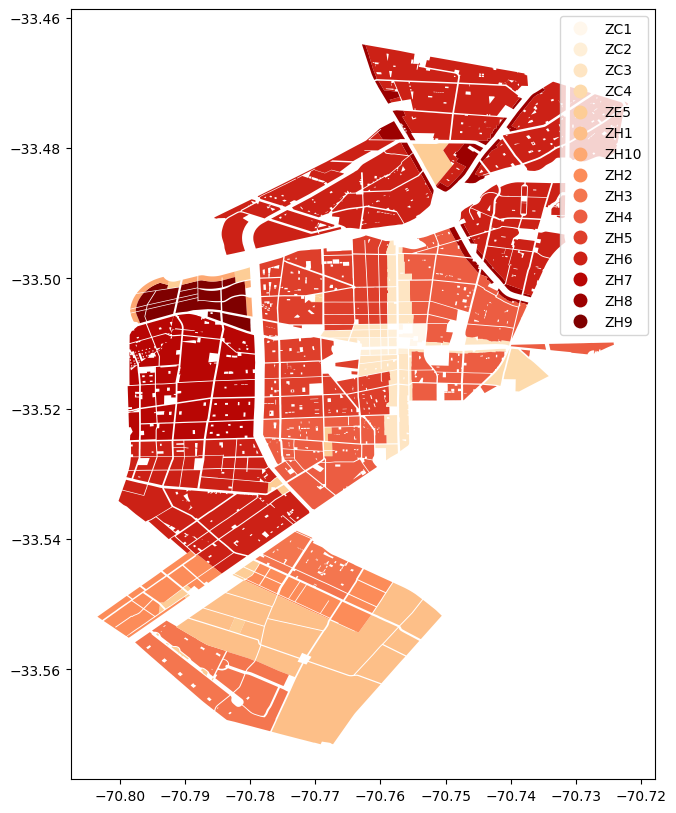

In [11]:
# Visualizar el GeoDataFrame que son las zonas habitacionales de Maipú
zonas_habitacionales_maipu.plot(column='ZONA', cmap='OrRd', legend=True, figsize=(10,10))

In [12]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_with_geometry
for feature in features_with_geometry:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

# Unir todos los polígonos en uno solo
zonas_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()


## Veamos la diferencia asi obtengamos los elementos detectador por el NDBI que se encuentras fuera de la cobertura de las zonas habitacionales del Plan Regulador Comunal

In [13]:
zonas_no_habitacionales = gpd.overlay(areas_urbanas_maipu,zonas_habitacionales_maipu, how='difference')
# creemos una mascara en el treshold del NDBI
ndbi_threshold_mask = ndbi_threshold.updateMask(ndbi_threshold)
# calculemos el area de la mascara
ndbi_threshold_area = ndbi_threshold_mask.multiply(ee.Image.pixelArea()).divide(1e6)
# utilicemos el ndbi para intsectarlo con las zonas habitacionales de maipu
ndbi_threshold_area_zonas_habitacionales_maipu = ndbi_threshold_area.clip(zonas_habitacionales_maipu_geometry)
# creemosle un buffer a zonas_habitacionales_maipu_geometry pequeño
zonas_habitacionales_maipu_geometry_buffer = zonas_habitacionales_maipu_geometry.buffer(50)
# unamos el buffer con zonas_habitacionales_maipu_geometry
zonas_habitacionales_maipu_geometry_buffer_union = zonas_habitacionales_maipu_geometry_buffer.union(zonas_habitacionales_maipu_geometry)
# pasemos esto a un geojson
zonas_habitacionales_maipu_geometry_buffer_union_geojson = zonas_habitacionales_maipu_geometry_buffer_union.getInfo()
# guardemoslo en un archivo
with open('zonas_habitacionales_maipu_geometry_buffer_union.geojson', 'w') as f:
    json.dump(zonas_habitacionales_maipu_geometry_buffer_union_geojson, f)

# carguemos el geojson con geopandas
zonas_habitacionales_maipu_geometry_buffer_union = gpd.read_file('zonas_habitacionales_maipu_geometry_buffer_union.geojson')

# tomemos solo el poligono de zonas_no_habitacionales
zonas_no_habitacionales_geometry = zonas_no_habitacionales.geometry[0]

features_no = zonas_no_habitacionales['geometry'].to_json()
# veamos features_no como un diccionario
features_no = json.loads(features_no)

# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_no
for feature in features_no['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

    
# Unir todos los polígonos en uno solo
zonas_no_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()

# ahora clipiemos el ndbi_threshold_area con zonas_no_habitacionales_maipu_geometry
ndbi_threshold_area_zonas_no_habitacionales = ndbi_threshold_area.clip(zonas_no_habitacionales_maipu_geometry)

In [14]:
zonas_no_habitacionales.head(1)

,FID,PROVINCIA,COMUNA,LOCALIDAD,MACRO_ýRE,ID,NORMA_PRMS,CAT_SUELO,ORIGEN_,U_PERMITID,SUP_M2,SUP_Hý,SECTOR,Shape_Leng,Shape_Area,Shape__Are,Shape__Len,geometry
0,156,Provincias del Gran Santiago,Comunas del Gran Santiago,--,None,148,Art. 2.2.1. Ãrea Urbana Metropolitana,Area Urbana,Ãrea Urbana Originada de LÃ­mite Urbano IPT C...,IPT Metropolitano Art. 3.1.1. y/o IPT Comunale...,6.396567e+08,0,None,281923.956865,6.396567e+08,9.221309e+08,338483.906467,"MULTIPOLYGON (((-70.73332 -33.51106, -70.73305..."


In [15]:
mapa = geemap.Map()
mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
mapa.addLayer(Maipu_2023, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, '2023')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_habitacionales_maipu')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_no_habitacionales')
mapa

Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

In [16]:
# de la clipped_image obtengamos las bandas 12,11,4 en Sentinel 2
clipped_image

# calculando el urban index como la normalizacion de la banda 8 y 12
urban_index = clipped_image.normalizedDifference(['B8', 'B12'])

# cipleando el urban index con zonas_habitacionales_maipu_geometry
urban_index_zonas_no_habitacionales_maipu = urban_index.clip(zonas_no_habitacionales_maipu_geometry)

# treshold para urban index
urban_index_threshold = urban_index_zonas_no_habitacionales_maipu.gte(0.1)

# clipiemos el urban index threshold con zonas_habitacionales_maipu_geometry


In [17]:
# veamos ahora alguna relacion entre el urban index y el ndbi
mapa = geemap.Map()

mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
# veamos las clipped image desde colores verde oliva a lila
mapa.addLayer(clipped_image, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, 'clipped_image')
mapa.addLayer(urban_index_zonas_no_habitacionales_maipu, {}, 'zonas_no_habitacionales_maipu_geometry')
mapa.addLayer(urban_index_threshold, {'min': 0, 'max': 1}, 'urban_index')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_habitacionales_maipu')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_no_habitacionales')
mapa

Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

In [18]:
# Define la URL de la consulta
url = "https://sitmaipu.cl/arcgis/rest/services/Servicios/PRC_Zonificacion/MapServer/1/query"

# Define los parámetros de la consulta
params = {
    "f": "geoJSON",
    "where": "ZONA='AR-4' OR ZONA='ZI2'",
    "outFields": "*",
    "returnGeometry": "true"
}

# Realiza la consulta
response = requests.get(url, params=params)

# Comprueba que la consulta fue exitosa
response.raise_for_status()

# Convierte la respuesta a JSON
data = response.json()

# Extrae las características (features) de la respuesta
features = data["features"]

# Filtra las características que tienen una geometría
features_with_geometry = [f for f in features if f["geometry"] is not None]

# crear un GeoDataFrame con los polígonos y guardando la descripción de cada polígono
zonas_industriales_maipu = gpd.GeoDataFrame.from_features(features_with_geometry)
zonas_industriales_maipu.crs = "EPSG:4326"
# Realizar la diferencia de los polígonos
areas_urbanas_sin_industrias = gpd.overlay(areas_urbanas_maipu, zonas_industriales_maipu, how='difference')

# a JSON
areas_urbanas_sin_industrias_json = areas_urbanas_sin_industrias.to_json()
areas_urbanas_sin_industrias_json = json.loads(areas_urbanas_sin_industrias_json)
areas_urbanas_sin_industrias_geometry = ee.Geometry.MultiPolygon(areas_urbanas_sin_industrias_json['features'][0]['geometry']['coordinates'])

<Axes: >

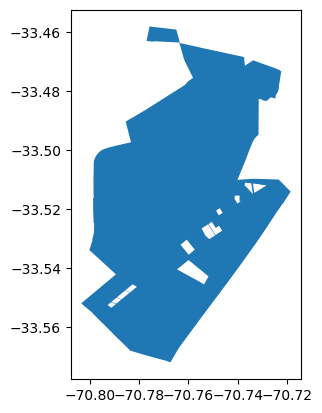

In [19]:
areas_urbanas_sin_industrias.plot()

In [20]:
ndbi_threshold_area_zonas_no_habitacionales = ndbi_threshold_area_zonas_no_habitacionales.clip(areas_urbanas_sin_industrias_geometry)

In [21]:
# Leer data_campamentos\catastro_Catastro2022_2023.geojson
import geopandas as gpd
cnc_2022 = gpd.read_file('data_campamentos\catastro_Catastro2022_2023.geojson').to_crs("EPSG:4326")

# Hacer clip con maipu 
cnc_2022_maipu = gpd.clip(cnc_2022, maipu)
cnc_2022_maipu.head(1)

cnc_2022_json = cnc_2022_maipu.to_json()
cnc_2022_json = json.loads(cnc_2022_json)

# iteremos en las features y guardemos la geometría de cada feature
cnc_2022_geometry = []
for feature in cnc_2022_json['features']:
    cnc_2022_geometry.append(feature['geometry']['coordinates'])

# convirtamos la lista de geometrías a un ee.Geometry.MultiPolygon
cnc_2022_geometry = ee.Geometry.MultiPolygon(cnc_2022_geometry)


#cnc_2022_geometry = ee.Geometry.MultiPolygon(cnc_2022_json['features'][1]['geometry']['coordinates'])

mapa = geemap.Map()

mapa.centerObject(cnc_2022_geometry, 12)
#Agreguemos mapa base

mapa.addLayer(Maipu_2023, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, 'clipped_image')
mapa.addLayer(cnc_2022_geometry, {'color': 'green'}, 'cnc_2022__geometry')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales, {}, 'zonas_no_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu, {}, 'zonas_habitacionales_maipu_geometry')
mapa

Map(center=[-33.492264128541414, -70.7783008617364], controls=(WidgetControl(options=['position', 'transparent…

In [22]:
# Sumar las areas de los poligonos de ndbi_threshold_area_zonas_no_habitacionales
ndbi_threshold_area_zonas_no_habitacionales_area_2023 = ndbi_threshold_area_zonas_no_habitacionales.geometry().area().getInfo()
# pasar de m2 a km2
ndbi_threshold_area_zonas_no_habitacionales_area_2023 = ndbi_threshold_area_zonas_no_habitacionales_area_2023 / 1000000
ndbi_threshold_area_zonas_no_habitacionales_area_2023

19.398732022389346

### Correciones realizadas

- Arregle los NDBI que teniamos, estaba utilizando otras capas y ahora como puedes ver esta muchoooo mejor.

- Estaba tomando en efecto el complemento de lo que detectaba el indice jajaj, esta arreglado tambien.

- cambie la query que se realiza eliminando la zona industrial y agregando los sectores de riesgo de gas y eso.



### Cosas que faltan

- Lograr filtrar bien las zonas industriales, el considerar las zonas elimina la disposicion de campamentos, por lo tanto no esta tan bien delimitado el sector industrial (opcion de solucion: eliminar las industrias grandes que encontramos en terrenos grande [ejemplo, COPEC.SA])

- Ligar los datos espacialmente con los indices ISMT

- intentar hacer algun grafico que muestre la distribucion de las clases sociales las cuales clasificaremos solo con el uso del indice ismt

- Probamos ya la tesis de que hay campamentos en ese sector, por lo que solo necesitamos diferenciar las cositas del territorio habitable.



### En verdad esta quedando bacan, mañana hago la presentación y estaré durante el día haciendo un poco del informe, dejo el docs adjuntado en el link de abajo


- [Informe escrito del proyecto](https://docs.google.com/document/d/15hVvo05p54Q-0YwcR30UQFePjZMg0EdY0xPGPX1_h3M/edit?usp=sharing)

#### Veremos si los asentamientos informales pertenecen a algun grupo en particular con caracteristicas similares entre ellos.

In [23]:
# Leer ISMT de data\ISMT\ISMT_ZC_all_v3_average.shp
ismt = gpd.read_file('data\ISMT\ISMT_ZC_all_v3_average.shp').to_crs(epsg=4326)
# Filtrar por la comuna de Maipu
ismt_maipu = ismt[ismt['nom_cmn'] == 'MAIPÚ'].reset_index(drop=True)
# Me quedo solo con 'prom_ismt', 'AVE_GSE', geocode
ismt_maipu = ismt_maipu[['prom_ismt', 'AVE_GSE', 'geocode']]


# leer data\ZONA_C17\ZONA_C17.shp
zona_c17 = gpd.read_file('data\ZONA_C17\ZONA_C17.shp').to_crs(epsg=4326)
zonas_maipu = zona_c17.loc[zona_c17['NOM_COMUNA']=='MAIPÚ'].reset_index(drop=True) 


# Hacer join entre ismt_maipu y zonas_maipu con geocode y GEOCODIGO
ismt_maipu_zonas = ismt_maipu.merge(zonas_maipu, left_on='geocode', right_on='GEOCODIGO', how='inner')
# Me quedo solo con comuna, LOC_ZON, prom_ismt, AVE_GSE, geoemtry
ismt_maipu_zonas = ismt_maipu_zonas[['NOM_COMUNA', 'LOC_ZON', 'prom_ismt', 'AVE_GSE', 'geometry']]
# Pasar de dataframe a geodataframe ismt_maipu_zonas con crs epsg:4674
ismt_maipu_zonas = gpd.GeoDataFrame(ismt_maipu_zonas, crs=4326)


# Leer data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp
pob_socioec = gpd.read_file('data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp').to_crs(epsg=4326)
# Intersectar maipu con pob_socioec
maipu_pob_socioec = gpd.overlay(pob_socioec, maipu, how='intersection')


# Dentro de una gemoetria de ismt_maipu_zonas hay varias geometrias de maipu_pob_socioec, por lo que todas estas manzanas se intersectan con la zona y estas manzanas heredan el prom_ismt de la zona a la que intersectan
# Hacer un spatial join entre ismt_maipu_zonas y maipu_pob_socioec con op='intersects'
ismt_maipu_zonas_pob_socioec = gpd.sjoin(maipu_pob_socioec , ismt_maipu_zonas, op='intersects')
# Dropear duplicados segun ID_MANZENT
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec.drop_duplicates(subset='ID_MANZENT', keep='first')

<Axes: >

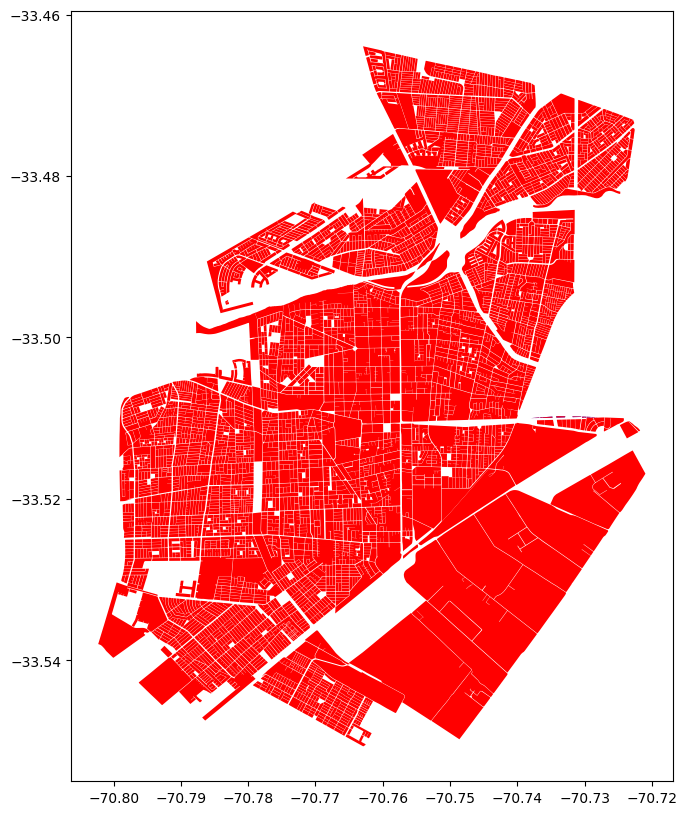

In [24]:
# obtener una lista de todos los ID_MANZENT de ismt_maipu_zonas_pob_socioec
id_manzent = ismt_maipu_zonas_pob_socioec['ID_MANZENT'].tolist()
# obtener una lista de todos los ID_MANZENT de maipu_pob_socioec
id_manzent2 = maipu_pob_socioec['ID_MANZENT'].tolist()
# Hacer la diferencia entre las dos listas
id_manzent3 = list(set(id_manzent2) - set(id_manzent))
# Filtrar maipu_pob_socioec por id_manzent3
maipu_pob_socioec_1 = maipu_pob_socioec[maipu_pob_socioec['ID_MANZENT'].isin(id_manzent3)].reset_index(drop=True)

# Graficar maipu_pob_socioec_1 y maipu_pob_socioec en una mismo plot juntos para ver en donde no se intersectan, con diferentes colores para cada uno
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
maipu_pob_socioec_1.plot(ax=ax, color='blue')
maipu_pob_socioec.plot(ax=ax, color='red')

In [25]:
for f in ['EDAD_65YMA','INMIGRANTE','PUEBLO','MUJERES','HOMBRES','EDAD_0A5','EDAD_15A64','EDAD_6A14','PERSONAS','TOTAL_VIV']:
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].replace('*',0)
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].astype('float')
    
ismt_maipu_zonas_pob_socioec=ismt_maipu_zonas_pob_socioec[ismt_maipu_zonas_pob_socioec['PERSONAS']>0].reset_index(drop=True)

# Normalizando los datos
ismt_maipu_zonas_pob_socioec['densidad']=ismt_maipu_zonas_pob_socioec['PERSONAS']/ismt_maipu_zonas_pob_socioec.geometry.area #personas por m2
ismt_maipu_zonas_pob_socioec['pct_aMayor']=ismt_maipu_zonas_pob_socioec['EDAD_65YMA']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_inm']=ismt_maipu_zonas_pob_socioec['INMIGRANTE']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_orig']=ismt_maipu_zonas_pob_socioec['PUEBLO']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_nna']=(ismt_maipu_zonas_pob_socioec['EDAD_0A5']+ismt_maipu_zonas_pob_socioec['EDAD_6A14'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_adult']=(ismt_maipu_zonas_pob_socioec['EDAD_15A64'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_mujeres']=(ismt_maipu_zonas_pob_socioec['MUJERES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_hombres']=(ismt_maipu_zonas_pob_socioec['HOMBRES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100

# Reordenar columnas y solo quedarme coin otdas aquellas que me interesan para el analisis
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec[['NOM_COMUNA', 'ID_MANZENT', 'prom_ismt', 'NSE', 'GSE_final', 'TOTAL_VIV', 'densidad', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres', 'geometry']]
ismt_maipu_zonas_pob_socioec.head(1)

,NOM_COMUNA,ID_MANZENT,prom_ismt,NSE,GSE_final,TOTAL_VIV,densidad,pct_aMayor,pct_inm,pct_orig,pct_nna,pct_adult,pct_mujeres,pct_hombres,geometry
0,MAIPÚ,13119201006001,0.835958,538.861076,C3,441.0,2.108087e+08,5.874587,2.574257,6.336634,19.933993,74.191419,51.287129,48.712871,"POLYGON ((-70.76015 -33.46445, -70.76006 -33.4..."


In [26]:
# Normalizar NSE, TOTAL_VIV, pct_aMayor, pct_inm, pct_orig, pct_nna, pct_adult, pct_mujeres, pct_hombres, utilizando la media y la desviacion estandar
ismt_maipu_zonas_pob_socioec['NSE'] = (ismt_maipu_zonas_pob_socioec['NSE'] - ismt_maipu_zonas_pob_socioec['NSE'].mean()) / ismt_maipu_zonas_pob_socioec['NSE'].std()
ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] = (ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] - ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].mean()) / ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].std()
ismt_maipu_zonas_pob_socioec['pct_aMayor'] = (ismt_maipu_zonas_pob_socioec['pct_aMayor'] - ismt_maipu_zonas_pob_socioec['pct_aMayor'].mean()) / ismt_maipu_zonas_pob_socioec['pct_aMayor'].std()
ismt_maipu_zonas_pob_socioec['pct_inm'] = (ismt_maipu_zonas_pob_socioec['pct_inm'] - ismt_maipu_zonas_pob_socioec['pct_inm'].mean()) / ismt_maipu_zonas_pob_socioec['pct_inm'].std()
ismt_maipu_zonas_pob_socioec['pct_orig'] = (ismt_maipu_zonas_pob_socioec['pct_orig'] - ismt_maipu_zonas_pob_socioec['pct_orig'].mean()) / ismt_maipu_zonas_pob_socioec['pct_orig'].std()
ismt_maipu_zonas_pob_socioec['pct_nna'] = (ismt_maipu_zonas_pob_socioec['pct_nna'] - ismt_maipu_zonas_pob_socioec['pct_nna'].mean()) / ismt_maipu_zonas_pob_socioec['pct_nna'].std()
ismt_maipu_zonas_pob_socioec['pct_adult'] = (ismt_maipu_zonas_pob_socioec['pct_adult'] - ismt_maipu_zonas_pob_socioec['pct_adult'].mean()) / ismt_maipu_zonas_pob_socioec['pct_adult'].std()
ismt_maipu_zonas_pob_socioec['pct_mujeres'] = (ismt_maipu_zonas_pob_socioec['pct_mujeres'] - ismt_maipu_zonas_pob_socioec['pct_mujeres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_mujeres'].std()
ismt_maipu_zonas_pob_socioec['pct_hombres'] = (ismt_maipu_zonas_pob_socioec['pct_hombres'] - ismt_maipu_zonas_pob_socioec['pct_hombres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_hombres'].std()
ismt_maipu_zonas_pob_socioec.head(1)

,NOM_COMUNA,ID_MANZENT,prom_ismt,NSE,GSE_final,TOTAL_VIV,densidad,pct_aMayor,pct_inm,pct_orig,pct_nna,pct_adult,pct_mujeres,pct_hombres,geometry
0,MAIPÚ,13119201006001,0.835958,0.074715,C3,9.940017,2.108087e+08,-0.489394,0.287186,-0.375529,0.791415,0.338051,-0.126608,0.157637,"POLYGON ((-70.76015 -33.46445, -70.76006 -33.4..."


In [27]:
# Indices que seran utilizados para el analisis
col_analisis = ['prom_ismt', 'NSE', 'TOTAL_VIV', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres']

In [28]:
# Regionalización (Clustering con restricción geográfica) con ismt_maipu_zonas_pob_socioec
#w = weights.Queen.from_dataframe(ismt_maipu_zonas_pob_socioec)
#w.transform ='R'
#w.sparse

In [29]:
# importar AgglomerativeClustering
#nclusters = 4
#model = AgglomerativeClustering(connectivity=w.sparse,n_clusters=nclusters)
#model.fit(ismt_maipu_zonas_pob_socioec[col_analisis])

In [30]:
#ismt_maipu_zonas_pob_socioec['ahc_spatial'] = model.labels_

# Figura
#f, ax = plt.subplots(1, figsize=(9, 9))
#ismt_maipu_zonas_pob_socioec.plot(column='ahc_spatial', categorical=True, legend=True, linewidth=0, ax=ax)
#ax.set_axis_off()
#plt.axis('equal')
#plt.title(r'Regiones Geodemográficas de Maipú (AHC)')
#plt.show()
# guardar imagen 
#f.savefig('ahc_spatial.png')

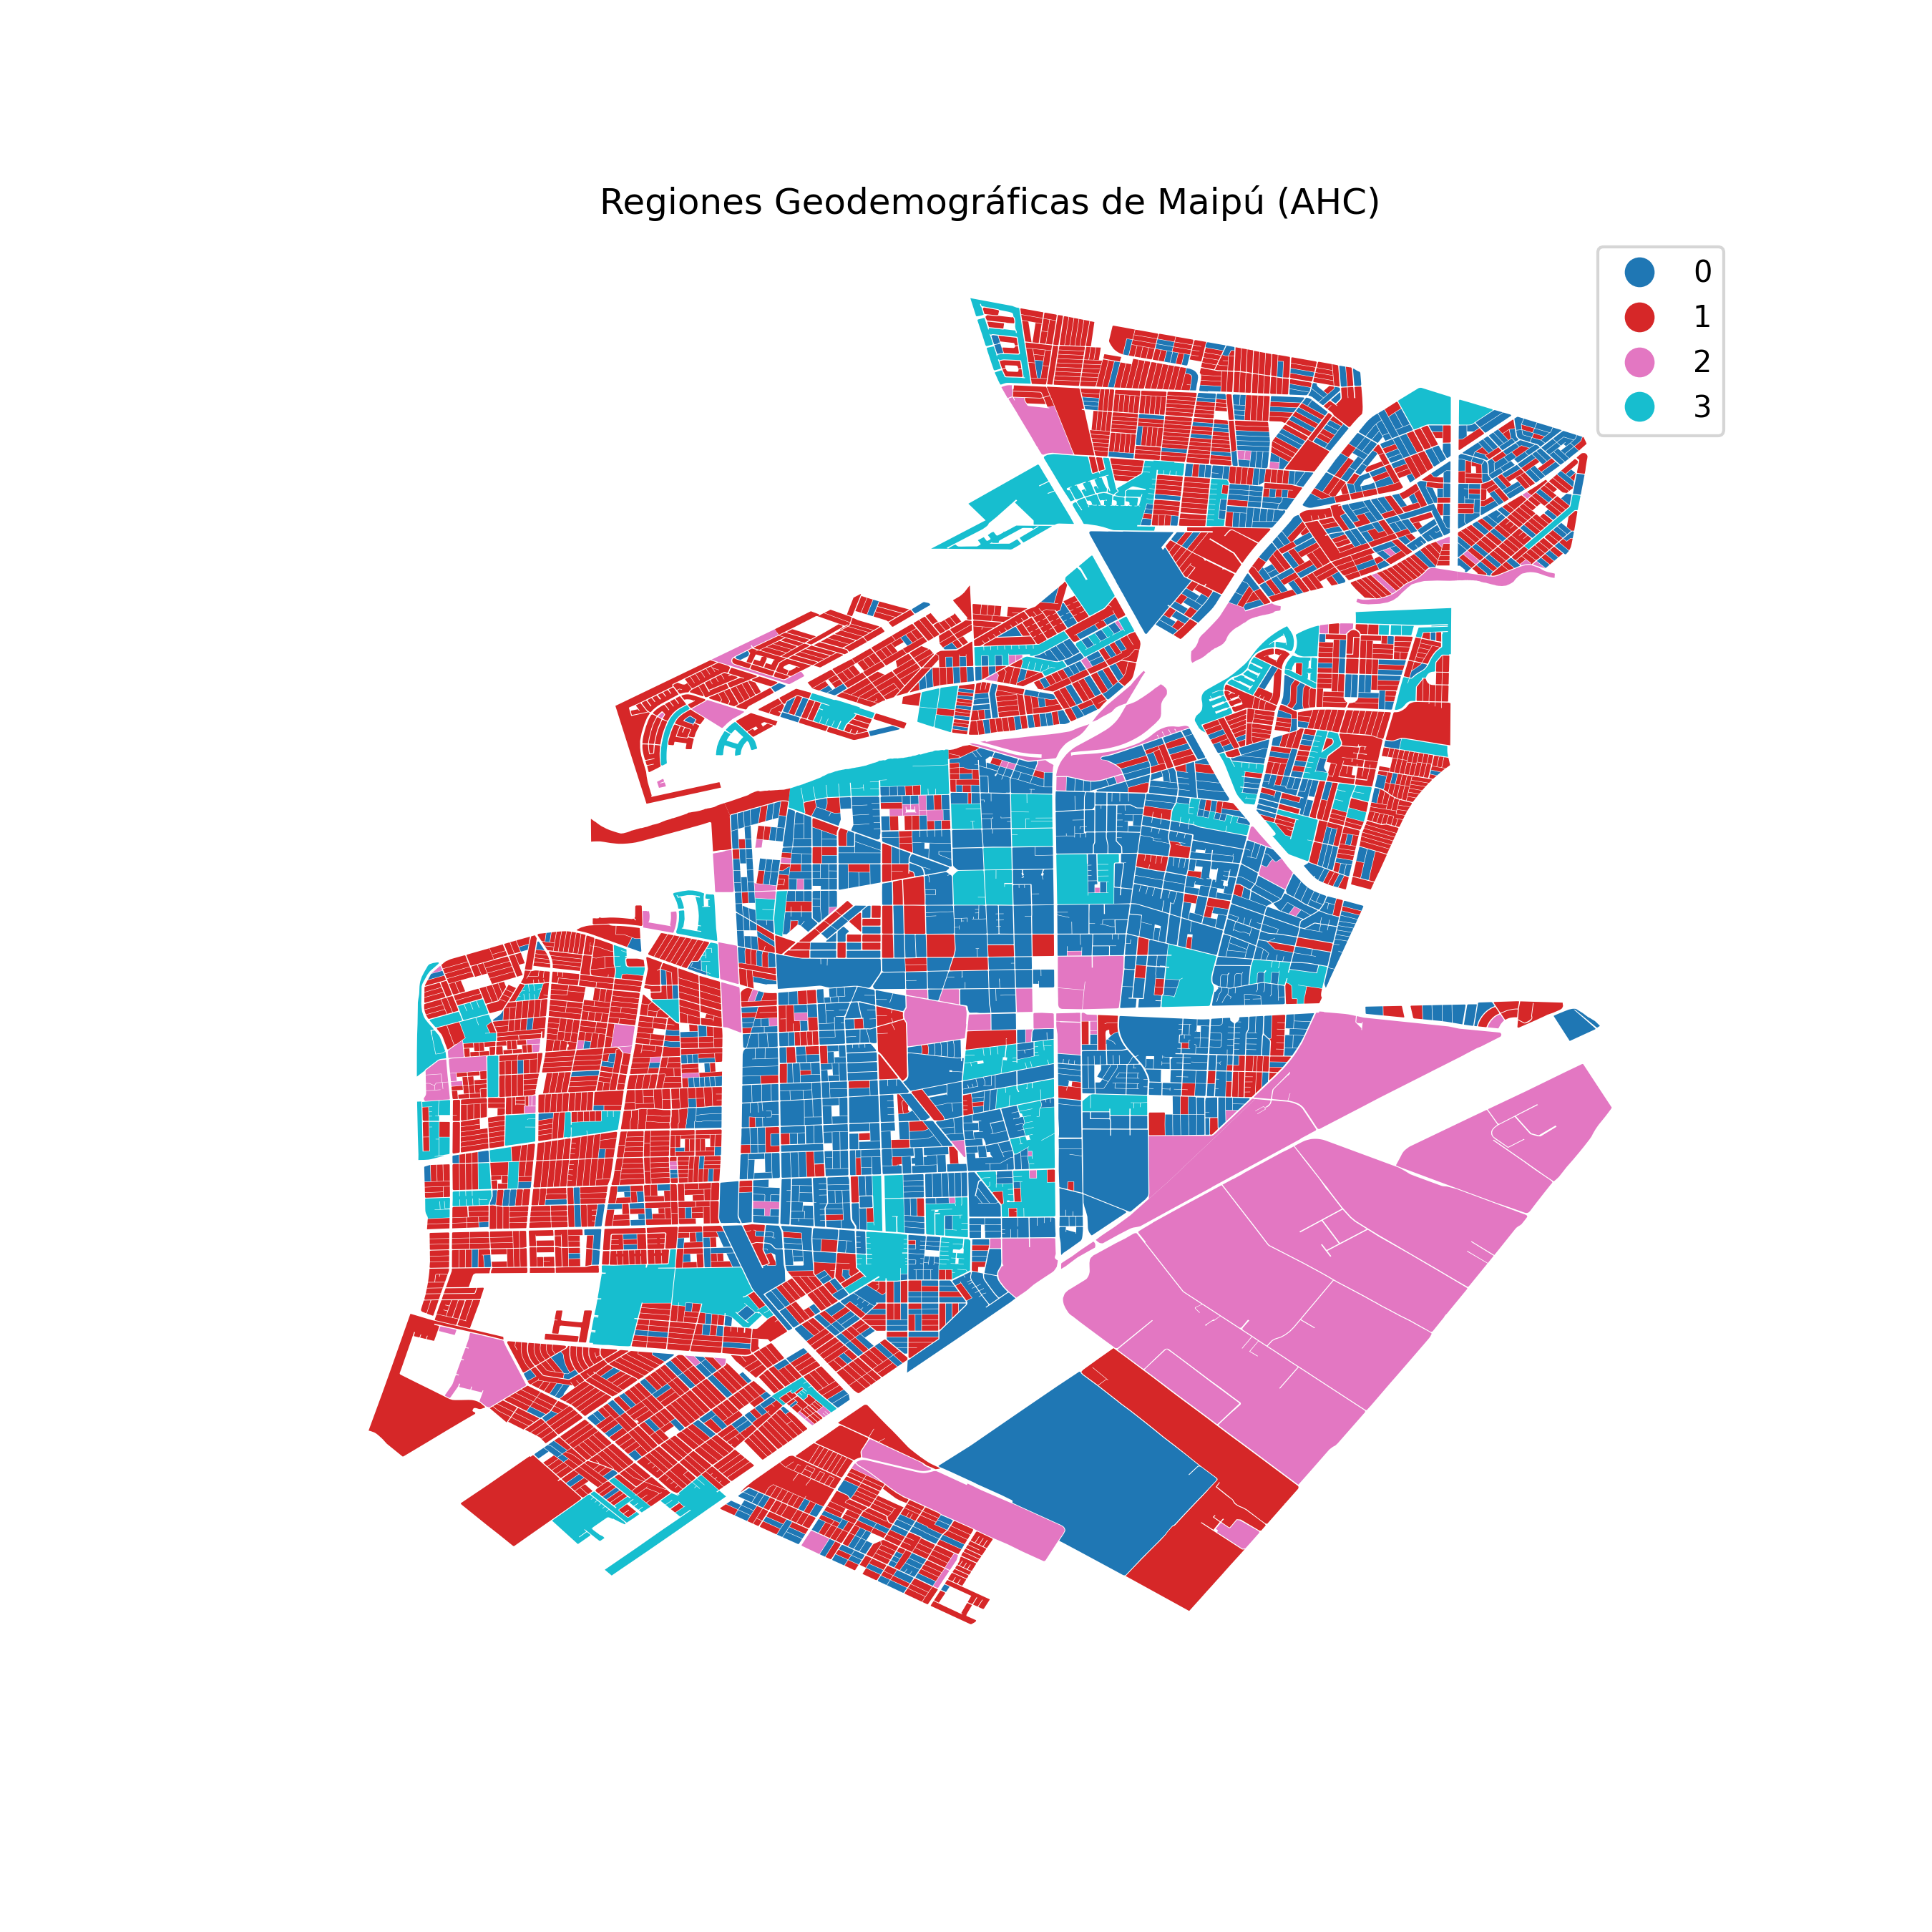

In [31]:
# mostrar imagen en el notebook
from IPython.display import Image
Image(filename='ahc_spatial.png')

In [32]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
#kahc_spatial = ismt_maipu_zonas_pob_socioec.groupby('ahc_spatial')[col_analisis].mean()
#kahc_spatial.T
# guardar tabla kahc_spatial.T
#kahc_spatial.T.to_csv('kahc_spatial.csv', sep=';', decimal='.', encoding='utf-8')

In [33]:
# Leer kahc_spatial.csv
kahc_spatial = pd.read_csv('kahc_spatial.csv', sep=';', decimal='.', encoding='utf-8')
kahc_spatial = kahc_spatial.set_index('Unnamed: 0')
kahc_spatial.index.name = None
kahc_spatial

,0,1,2,3
prom_ismt,0.801399,0.802133,0.792705,0.808646
NSE,0.307534,-0.032852,-3.735262,-0.035133
TOTAL_VIV,-0.207138,-0.048949,-0.166000,4.871564
pct_aMayor,0.802426,-0.472664,-0.572871,-0.205341
pct_inm,0.138086,-0.109300,0.115400,0.456932
pct_orig,-0.262212,0.174908,-0.355805,0.137900
pct_nna,-0.646166,0.388117,-0.344011,0.867284
pct_adult,-0.336303,0.314992,-2.448750,0.028584
pct_mujeres,0.148134,-0.056573,-0.950029,0.101387
pct_hombres,-0.120253,0.086800,-0.195376,-0.072971


In [34]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name, overlay=True, control=True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer

In [35]:
# Comparar el 2019 con el 2023

In [36]:
aoi = zonas_urbanas_geometry

collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate('2019-01-01', '2019-06-28').sort('CLOUDY_PIXEL_PERCENTAGE',True)

#tomemos una imagen random de la collection
lest_cloudly = collection.toList(72).get(1)

#clip the image to the aoi
clipped_image_2019 = ee.Image(lest_cloudly).clip(aoi)

In [37]:
# obtener la fecha de la imagen
date = ee.Date(clipped_image_2019.get('system:time_start')).format('YYYY-MM-dd').getInfo()
date

'2019-03-25'

In [38]:
# calculemos el NDBI

ndbi_2019 =  clipped_image_2019.normalizedDifference(['B11', 'B8'])

ndbi_vis_params = {'min': -1, 'max': 1, 'palette': ['lightgreen','purple']}

# calculemops el NDVI

ndvi_2019 = clipped_image_2019.normalizedDifference(['B8', 'B4'])

ndvi_vis_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white','green']}

# creemosu un trheshold para el ndvi
ndvi_threshold_2019 = ndvi.gt(0)

ndvi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

ndbi_threshold_2019 = ndbi.gt(0.02)

ndbi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['green','purple']}

# veamos la imagen del 2019 clipeada al zona urbana de maipu
Maipu_2019 = clipped_image_2019.clip(zonas_urbanas_geometry)

In [39]:
#visualicemos el ndbi

Map = geemap.Map()

Map.centerObject(zonas_urbanas_geometry, 12)

Map.addLayer(clipped_image_2019, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2019')
Map.addLayer(ndbi_threshold_2019, ndbi_threshold_vis_params, 'NDBI')
Map.addLayer(ndbi_2019,ndbi_vis_params, 'sgsd')

Map

Map(center=[-33.517396555511816, -70.76292036796465], controls=(WidgetControl(options=['position', 'transparen…

In [40]:
zonas_no_habitacionales = gpd.overlay(areas_urbanas_maipu,zonas_habitacionales_maipu, how='difference')
# creemos una mascara en el treshold del NDBI
ndbi_threshold_mask_2019 = ndbi_threshold_2019.updateMask(ndbi_threshold_2019)
# calculemos el area de la mascara
ndbi_threshold_area_2019 = ndbi_threshold_mask_2019.multiply(ee.Image.pixelArea()).divide(1e6)
# utilicemos el ndbi para intsectarlo con las zonas habitacionales de maipu
ndbi_threshold_area_zonas_habitacionales_maipu_2019 = ndbi_threshold_area_2019.clip(zonas_habitacionales_maipu_geometry)
# creemosle un buffer a zonas_habitacionales_maipu_geometry pequeño
zonas_habitacionales_maipu_geometry_buffer_2019 = zonas_habitacionales_maipu_geometry.buffer(50)
# unamos el buffer con zonas_habitacionales_maipu_geometry
zonas_habitacionales_maipu_geometry_buffer_union_2019 = zonas_habitacionales_maipu_geometry_buffer_2019.union(zonas_habitacionales_maipu_geometry)
# pasemos esto a un geojson
zonas_habitacionales_maipu_geometry_buffer_union_geojson_2019 = zonas_habitacionales_maipu_geometry_buffer_union_2019.getInfo()
# guardemoslo en un archivo
with open('zonas_habitacionales_maipu_geometry_buffer_union.geojson', 'w') as f:
    json.dump(zonas_habitacionales_maipu_geometry_buffer_union_geojson_2019, f)

# carguemos el geojson con geopandas
zonas_habitacionales_maipu_geometry_buffer_union_2019 = gpd.read_file('zonas_habitacionales_maipu_geometry_buffer_union.geojson')

# tomemos solo el poligono de zonas_no_habitacionales
zonas_no_habitacionales_geometry = zonas_no_habitacionales.geometry[0]

features_no = zonas_no_habitacionales['geometry'].to_json()
# veamos features_no como un diccionario
features_no = json.loads(features_no)

# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_no
for feature in features_no['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

    
# Unir todos los polígonos en uno solo
zonas_no_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()

# ahora clipiemos el ndbi_threshold_area con zonas_no_habitacionales_maipu_geometry
ndbi_threshold_area_zonas_no_habitacionales_2019 = ndbi_threshold_area_2019.clip(zonas_no_habitacionales_maipu_geometry)

In [41]:
mapa = geemap.Map()
mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
mapa.addLayer(Maipu_2019, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, '2019')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu_2019, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_habitacionales_maipu')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales_2019, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_no_habitacionales')
mapa

Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

In [42]:
ndbi_threshold_area_zonas_no_habitacionales = ndbi_threshold_area_zonas_no_habitacionales_2019.clip(areas_urbanas_sin_industrias_geometry)

In [43]:
mapa = geemap.Map()

mapa.centerObject(cnc_2022_geometry, 12)
#Agreguemos mapa base

mapa.addLayer(Maipu_2019, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, 'clipped_image')
mapa.addLayer(cnc_2022_geometry, {'color': 'green'}, 'cnc_2022__geometry')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales_2019, {}, 'zonas_no_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu_2019, {}, 'zonas_habitacionales_maipu_geometry')
mapa

Map(center=[-33.492264128541414, -70.7783008617364], controls=(WidgetControl(options=['position', 'transparent…

In [44]:
# Sumar las areas de los poligonos de ndbi_threshold_area_zonas_no_habitacionales
ndbi_threshold_area_zonas_no_habitacionales_area_2019 = ndbi_threshold_area_zonas_no_habitacionales_2019.geometry().area().getInfo()
# pasar de m2 a km2
ndbi_threshold_area_zonas_no_habitacionales_area_2019 = ndbi_threshold_area_zonas_no_habitacionales_area_2019/1000000

In [45]:
ndbi_threshold_area_zonas_no_habitacionales_area_2019

20.6928465482709

### veamos que el resultado para este caso es efecto de la imágen el cual no nos beneficia para nada

In [46]:
# clipeemos la imagen de ndbi_threshold_area_zonas_no_habitacionales_maipu con cnc_2022_geometry
campamentos_encontrados = ndbi_threshold_area_zonas_no_habitacionales.clip(cnc_2022_geometry)

In [47]:
densidades  = gpd.sjoin(maipu_pob_socioec , ismt_maipu_zonas, op='intersects')

In [48]:
densidades['PERSONAS']

9       1515
10        71
11       178
12       109
14       155
        ... 
3761     153
3766     414
3768      35
3772      79
3773     359
Name: PERSONAS, Length: 3924, dtype: int64

In [49]:
densidades['TOTAL_VIV']

9       441
10       20
11       52
12       28
14       48
       ... 
3761     50
3766    126
3768     12
3772     24
3773    108
Name: TOTAL_VIV, Length: 3924, dtype: int64

In [50]:
# Creemos una visualizacion en un folium map para ver la distribucion de los ISMT en la comuna de Maipu
ismt_maipu_zonas_pob_socioec_folium = ismt_maipu_zonas_pob_socioec[['NOM_COMUNA', 'ID_MANZENT', 'prom_ismt', 'NSE', 'GSE_final', 'TOTAL_VIV', 'densidad', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres', 'geometry']]


centro = [-33.518247, -70.778884]
zoom = 13

mapa = folium.Map(location=centro, zoom_start=zoom,tiles="OpenStreetMap")

# Agregar la imagen al mapa

mapa.add_ee_layer(Maipu_2023, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB')
mapa.add_ee_layer(ndbi_threshold_area_zonas_no_habitacionales, {'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'edificaciones en zonas no habitacionales 2023')
mapa.add_ee_layer(ndbi_threshold_area_zonas_no_habitacionales_2019, {'min': 0, 'max': 1, 'palette': ['yellow', 'white']}, 'edificaciones en zonas no habitacionales 2019')


mapa.add_ee_layer(campamentos_encontrados, {'min': 0, 'max': 1, 'palette': ['blue', 'white']}, 'campamentos_encontrados')


capa_choropleth = folium.Choropleth(
                  geo_data=ismt_maipu_zonas_pob_socioec_folium,
                    name='ISMT Promedio por Manzana',
                    data=ismt_maipu_zonas_pob_socioec_folium,
                    columns=['ID_MANZENT', 'prom_ismt'],
                    key_on='feature.properties.ID_MANZENT',
                    fill_color='YlOrRd',
                    fill_opacity=0.7,
                    line_opacity=0.2,
                    legend_name='ISM T'
                ).add_to(mapa)

# agreguemos una capa choropleth con la densidad de poblacion
capa_choropleth_personas = folium.Choropleth(
                    geo_data=densidades,
                    name='Densidad de Poblacion',
                    data=densidades,
                    columns=['ID_MANZENT', 'PERSONAS'],
                    key_on='feature.properties.ID_MANZENT',
                    fill_color='Oranges',
                    fill_opacity=0.7,
                    line_opacity=0.2,
                    legend_name='Densidad de Poblacion'
                ).add_to(mapa)  

capa_choropleth_viviendas = folium.Choropleth(
                    geo_data=densidades,
                    name='Total de viviendas',
                    data=densidades,
                    columns=['ID_MANZENT', 'TOTAL_VIV'],
                    key_on='feature.properties.ID_MANZENT',
                    # demosle color de paleta azulado
                    fill_color='Blues',
                    fill_opacity=0.7,
                    line_opacity=0.2,
                    legend_name='Densidad de Poblacion'
                ).add_to(mapa)  

# agreguemos una capa de zonas_maipu
folium.GeoJson(
    ismt_maipu_zonas_pob_socioec,
    name='Zonas Maipu',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(mapa)


folium.GeoJson(
    cnc_2022_maipu,
    name='Campamentos Maipú Techo',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'green',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(mapa)


# Agregar control de capas
folium.LayerControl().add_to(mapa)

# agregar titulo al mapa
title_html = '''    <h3 align="center" style="font-size:20px"><b>{}</b></h3>'''.format("Mapa Maipú")
mapa.get_root().html.add_child(folium.Element(title_html))

# Guardar el mapa 
mapa.save('Mapa_proyecto.html')
